# MNIST neural network demo

### A project by Sam Greydanus. <a href="https://opensource.org/licenses/MIT">MIT license</a>

This is a vanilla two-layer neural network for solving the MNIST written digit classification task. When I was first learning how to use neural networks, backpropagation was by far the most confusing part.

I've broken the gradient computations into several smaller functions and included mathematical explanations of each step to make backprop more transparent

## Load dependencies and data

In [1]:
import numpy as np
import cPickle as pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Hyperparameters

In [2]:
resume = False
batch_size = 16
lr = 2e-2
reg = 1e-4
h1_size = 100 # first hidden layer
h2_size = 10 # second hidden layer
D = 28*28 # dimensionality

## Model Initialization

In [3]:
model = {}
# first layer
model['W1'] = np.random.randn(D,h1_size) / np.sqrt(h1_size) # Xavier initialization
model['b1'] = np.random.randn(1,h1_size) / np.sqrt(h1_size) # see http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf
#second layer
model['W2'] = np.random.randn(h1_size,h2_size) / np.sqrt(h2_size)
model['b2'] = np.random.randn(1,h2_size) / np.sqrt(h2_size)

## Forward propagation

### x $\cdot$ W+b function

The **x $\cdot$ W+b** operation is just a linear transformation plus a constant. For a given input $x_j$ and output $h_k$ we have:
$$h_k = x_jW_{jk} + b_k $$

In [4]:
def xW_plus_b(x, W, b):
    return np.dot(x,W) + b # in some cases you can even drop the bias b

### Softmax function

The softmax function is $p_k=\frac{e^{z_k}}{\sum_i e^{z_i}}$

In [5]:
def softmax(x):
    maxes = np.amax(x, axis=1, keepdims=True)
    e = np.exp(x - maxes) # improves numerics
    dist = e / np.sum(e, axis=1, keepdims=True)
    return dist

### ReLU function

The ReLU function is $z_i=sign(h_i)$

In [6]:
def relu(x):
    x[x<0] = 0
    return x

### Putting it together

In [7]:
def forward(X, model):
    # evaluate class scores, [N x K]
    hs = [] # we'll need the h's for computing gradients
    
    z1 = xW_plus_b(X, model['W1'], model['b1'])
    h1 = relu(z1); hs.append(h1)
    
    z2 = xW_plus_b(h1, model['W2'], model['b2'])
    h2 = relu(z2); hs.append(h2)
    
    probs = softmax(h2)
    return probs, hs

## Backpropagation

### Gradient of the softmax

The original softmax function is:
$$p_k=\frac{e^{z_k}}{\sum_i e^{z_i}}$$
We're using a cross entropy loss function which looks like
$$L_i=-log(p_k)$$
Taking the gradient of $L$ with respect to $f_k$, we get
$$\frac{\partial L_i}{\partial z_k}=\frac{\partial}{\partial z_k}\left(-log(e^{z_k}) + log(\sum_i e^{z_i}) \right) = \frac{\partial}{\partial z_k}\left(-z_k + log(e^{z_1} + \ldots + e^{z_k} + \ldots + e^{z_n}) \right)$$
$$\frac{\partial L_i}{\partial z_k}=-\mathbb{1}(y_i=k) + \frac{e^{z_k}}{(e^{z_1} + \ldots + e^{z_k} + \ldots + e^{z_n})}$$
$$\frac{\partial L_i}{\partial z_k}= -\mathbb{1}(y_i=k) + p_k$$
Now we know how to calculate the whole gradient $\frac{\partial L}{\partial z_k}$

In [8]:
def dsoftmax(h, y, batch_size):
    h[range(batch_size),y] -= 1
    return h/y.shape[0] # divide by batch size

### Gradient of the ReLU

Propagating the gradient through the ReLU looks like:
$$\frac{\partial L}{\partial z_k} \frac{\partial z_k}{\partial h_k} =\frac{\partial}{\partial z_k}\left( sign(h_k) \right) =
\left\{
        \begin{array}{ll}
             \frac{\partial L}{\partial z_k} * 1 & \quad h \ge 0\\
            0 & \quad \mathrm{otherwise}
        \end{array}
    \right.$$
Since we know $\frac{\partial L}{\partial z_k}$ from calculations above, we can also calculate $\frac{\partial L}{\partial h_k}$

In [9]:
def drelu(dz, h):
    dz[h <= 0] = 0 # backprop relu
    return dz

### Gradient of x $\cdot$ W+b

The **x $\cdot$ W+b** operation is just a matrix dot product plus a constant vector $b$. We can break it into indices as follows:
$$ h_k = x_j*W_{jk} + b_k $$

Now we just need to propagate the gradient through this function.

$$\frac{\partial L}{\partial h_k} \frac{\partial h_k}{\partial x_j} = \frac{\partial L}{\partial h_k} \frac{\partial}{\partial x_j} \left( x_j*W_{jk} + b_k \right) = \frac{\partial L}{\partial h_k} W_{jk}$$

In practice, we'd like to vectorize this calculation. The best way to do this is with a matrix dot product
$$\frac{\partial L}{\partial x_j} = \frac{\partial L}{\partial h} \cdot W^\intercal$$

In [10]:
def dxW_plus_b(dh, model):
    return np.dot(dh, model['W2'].T)

### Putting it together

In [11]:
def backward(y, probs, hs, model):
    grads = { k : np.zeros_like(v) for k,v in model.iteritems() }
    dh2 = dsoftmax(probs, y, batch_size)
    
    # second hidden layer
    grads['W2'] = np.dot(hs[0].T, dh2)
    grads['b2'] = np.sum(dh2, axis=0, keepdims=True)

    # first hidden layer
    dh1 = dxW_plus_b(dh2, model)
    dh1 = drelu(dh1, hs[0]) # backprop through relu
    grads['W1'] = np.dot(X.T, dh1)
    grads['b1'] = np.sum(dh1, axis=0, keepdims=True)
    return grads

## Evaluation metric

In [12]:
# evaluate training set accuracy
def eval_model(model):
    X = mnist.test.images
    y = mnist.test.labels
    hidden_layer = np.maximum(0, np.dot(X, model['W1']) + model['b1'])
    scores = np.dot(hidden_layer, model['W2']) + model['b2']
    predicted_class = np.argmax(scores, axis=1)
    return (np.mean(predicted_class == y))

## Gradient descent loop

### A note on regularization

I've added L2 regularization to the cost and gradients here even though I didn't touch on it in the _Gradients_ section above. Here's how it works.

Overfitting is a problem which occurs when a model fits itself to individual examples in training data. This prevents it from generalizing well on new data. One way that neural networks overfit is by making certain weights very large; we use L2 Regularization to prevent this.

The idea of L2 regularization is to add a penalty - the _regularization loss_ - to the loss function which scales with the sum square of all parameters in the model.
$$L_{\mathrm{regularization}} = \frac{1}{2} \gamma \theta \cdot \theta$$

Where $L_\mathrm{regularization}$ is regularization loss, $\gamma$ is a scaling hyperparameter, and $\theta$ is an 1D vector of all the training parameters. The gradient, then, has the simple form of

$$\frac{\partial L_\mathrm{regularization}}{\partial \theta} = \gamma \theta$$

In [13]:
loss_history = []
smoothing_factor = 0.95
running_loss = 0
for i in xrange(10000):
    X, y = mnist.train.next_batch(batch_size)
    
    probs, hs = forward(X, model)
    
    # compute the loss: average cross-entropy loss and L2 regularization
    y_logprobs = -np.log(probs[range(batch_size),y]) # we want probs on the y labels to be large
    reg_loss = 0.5*reg*np.sum([np.sum(w*w) for w in model.itervalues()])
    loss = np.sum(y_logprobs)/batch_size

    grads = backward(y, probs, hs, model) # data gradients
    grads = {k : v+reg*model[k] for (k,v) in grads.iteritems()} # L2 gradients
    
    # update parameters
    model = {k : model[k] - lr*grads[k] for (k,v) in grads.iteritems()}
    
    # boring book-keeping
    running_loss = smoothing_factor*running_loss + (1-smoothing_factor)*loss
    if i % 1000 == 0: print "iteration {}: test accuracy {:3f}".format(i, eval_model(model))
    if i % 250 == 0: print "\titeration %d: loss %f" % (i, running_loss)
    if i % 10 == 0: loss_history.append((i,running_loss))

iteration 0: test accuracy 0.103900
	iteration 0: loss 0.158473
	iteration 250: loss 0.628053
	iteration 500: loss 0.536293
	iteration 750: loss 0.412299
iteration 1000: test accuracy 0.901100
	iteration 1000: loss 0.424514
	iteration 1250: loss 0.367856
	iteration 1500: loss 0.285636
	iteration 1750: loss 0.298698
iteration 2000: test accuracy 0.916600
	iteration 2000: loss 0.218804
	iteration 2250: loss 0.241253
	iteration 2500: loss 0.300593
	iteration 2750: loss 0.330159
iteration 3000: test accuracy 0.931800
	iteration 3000: loss 0.363576
	iteration 3250: loss 0.182368
	iteration 3500: loss 0.227460
	iteration 3750: loss 0.164999
iteration 4000: test accuracy 0.937300
	iteration 4000: loss 0.245600
	iteration 4250: loss 0.216319
	iteration 4500: loss 0.186088
	iteration 4750: loss 0.202465
iteration 5000: test accuracy 0.941800
	iteration 5000: loss 0.221644
	iteration 5250: loss 0.198244
	iteration 5500: loss 0.163444
	iteration 5750: loss 0.219502
iteration 6000: test accuracy 0

## Visualize training loss

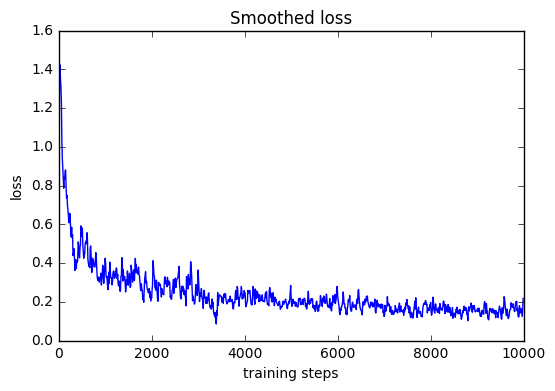

In [14]:
plt.title("Smoothed loss")
plt.xlabel("training steps")
plt.ylabel("loss")

train_steps, smoothed_losses = zip(*loss_history)
plt.plot(train_steps, smoothed_losses)
plt.show()

## Sample model

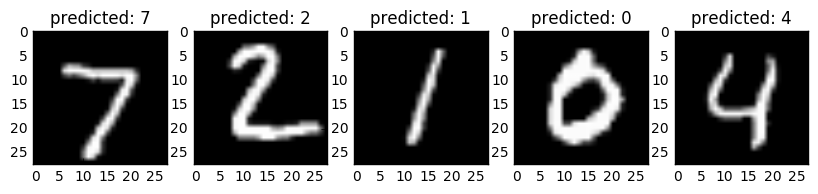

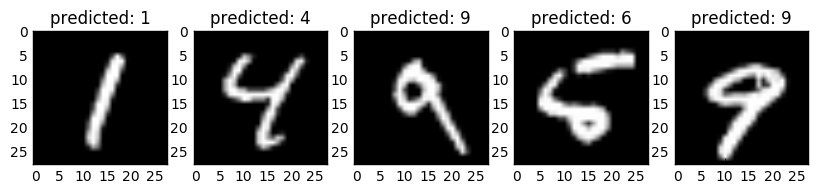

In [15]:
X = mnist.test.images
y = mnist.test.labels
hidden_layer = np.maximum(0, np.dot(X, model['W1']) + model['b1'])
scores = np.dot(hidden_layer, model['W2']) + model['b2']
predicted_class = np.argmax(scores, axis=1)

for i in range(0,10,5):
    img1 = np.reshape(X[i+0,:], (28,28))
    img2 = np.reshape(X[i+1,:], (28,28))
    img3 = np.reshape(X[i+2,:], (28,28))
    img4 = np.reshape(X[i+3,:], (28,28))
    img5 = np.reshape(X[i+4,:], (28,28))
    plt.figure(i, figsize=(10,4))
    plt.subplot(151) ; plt.title("predicted: " + str(predicted_class[i]))
    plt.imshow(img1, cmap=cm.gray)
    plt.subplot(152) ; plt.title("predicted: " + str(predicted_class[i+1]))
    plt.imshow(img2, cmap=cm.gray)
    plt.subplot(153) ; plt.title("predicted: " + str(predicted_class[i+2]))
    plt.imshow(img3, cmap=cm.gray)
    plt.subplot(154) ; plt.title("predicted: " + str(predicted_class[i+3]))
    plt.imshow(img4, cmap=cm.gray)
    plt.subplot(155) ; plt.title("predicted: " + str(predicted_class[i+4]))
    plt.imshow(img5, cmap=cm.gray)